In [496]:
# YIKAI MAO

# variational quantum algorithm generator

In [497]:
# reproducibility
%env PYTHONHASHSEED=0

# Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from qiskit.transpiler.passes import RemoveBarriers
from qiskit.circuit import Parameter
from qiskit.circuit.library import Diagonal, QFT, GroverOperator, ZGate, EfficientSU2, ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.extensions import Initialize

print('*'*104)
print("available simulators:")
display(Aer.backends())
print('*'*104)

# other libraries
from tqdm import tqdm #tqdm(iterable)
from random import sample, choice
import math
import numpy as np
import networkx as nx
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
from sklearn.metrics import r2_score
import pickle

env: PYTHONHASHSEED=0
********************************************************************************************************
available simulators:


[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

********************************************************************************************************


In [498]:
# utility functions

def run_ideal_simulation(circuit, shots, optimization_level, seed, show_plot, show_counts):
    # assume perfect device with no noise
    # circuit = circuit to simulate, not transpiled
    # shots = how many shots to run
    # optimization_level = passed to the transpiler, min = 0, max = 3
    # seed = random seed for simultaion, can be None
    # show_counts = T/F, plot result or not

    simulator = Aer.get_backend('aer_simulator')
    temp_qc = transpile(circuit, simulator, optimization_level=optimization_level)
    job_temp = simulator.run(temp_qc, shots=shots, seed_simulator=seed)
    temp_results = job_temp.result()
    
    # build simulation result dict
    raw_counts = temp_results.get_counts()
    # print("raw counts:\n", raw_counts)
    num_clbits = circuit.num_clbits
    ideal_result_dict = {}

    # sorting the raw counts, add state zero
    for i in range(pow(2, num_clbits)):
        bin_str = format(i, str('0>' + str(num_clbits) + 'b'))
        if bin_str not in raw_counts:
            ideal_result_dict[bin_str] = 0
        else:
            ideal_result_dict[bin_str] = raw_counts[bin_str]

    if show_plot:
        plot = plot_histogram(raw_counts, title='ideal simulation')
        display(plot)
            
    if show_counts:
        print('sorted counts:')
        print(ideal_result_dict)
    
    return ideal_result_dict, raw_counts

def decomposer(circ, level=1):
    # decompose the circuit to see the basis gates
    # level = how many times to decompose
    
    decomposed_circ = circ
    
    for i in range(level):
        decomposed_circ = decomposed_circ.decompose()
        
    return decomposed_circ

# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def random_bin_str(width, zero=False):
    # return random binary string based on width
    # zero = T/F, T = include 0, F = do not return 0
    # width cannot be 0
    
    if width == 0:
        return None
    
    b = np.random.randint(2, size=width)
    b_str = ''.join(map(str, b.tolist()))
    
    if zero==True:
        return b_str
    
    else:
        while '1' not in b_str:
            b = np.random.randint(2, size=width)
            b_str = ''.join(map(str, b.tolist()))
        
        return b_str

In [499]:
# https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/qaoa.ipynb

def qaoa(n, options=[]):
    # n is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # options = [graph, parameters]
    # graph = if 'cycle', use the default cycle graph. Else, supply custom networkx graph
    # parameters = if 'random', use random gamma/beta. Else, supply gamma and beta
    
    graph = options[0]
    parameters = options[1]
    
    if graph == 'cycle':
        graph = nx.cycle_graph(n)
        # print(list(cycle_graph.edges()))
        # nx.draw(cycle_graph)
    else:
        graph = options[0]
        
    gamma = Parameter("$\\gamma$")
    beta = Parameter("$\\beta$")
    if parameters == 'random':
        gamma = np.random.uniform(low=-pi, high=pi)
        beta = np.random.uniform(low=-pi, high=pi)
    else:
        gamma = parameters[0]
        beta = parameters[1]
    
    qaoa_circuit = QuantumCircuit(n)
    
    for qubit in range(n):
        qaoa_circuit.h(qubit)
    
    qaoa_circuit.barrier()
    
    # gamma = pi/8.000 # maxcut n=4
    for pair in list(graph.edges()):  # pairs of nodes
        qaoa_circuit.rzz(2 * gamma, pair[0], pair[1])
        qaoa_circuit.barrier()
    
    # beta = pi/2.666 # maxcut n=4
    for qubit in range(n):
        qaoa_circuit.rx(2 * beta, qubit)
    
    qaoa_circuit.measure_all()
    
    return qaoa_circuit

In [500]:
# https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/vqe-molecules.ipynb
# https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.EfficientSU2
# https://www.youtube.com/watch?v=XF0eMYKd9ks

def vqe(n, options=[]):
    # n is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # options = [repeat, gates, entanglement]
    # repeat = how many times to repeat the variational form
    # gates = single qubit gates used in the variational form (['ry', 'rz'])
    # entanglement = CX between the single qubit gates (full, linear, reverse_linear, circular, sca)
    # parameters = a bind_dict for assigning the parameters to the gates, or 'random'
    
    repeat = options[0]
    gates = options[1]
    entanglement = options[2]
    parameters = options[3]
    
    vqe_circuit = EfficientSU2(
        num_qubits=n, 
        reps=repeat, 
        su2_gates=gates, 
        entanglement=entanglement, 
        parameter_prefix='th', 
        insert_barriers=True)
    
    if parameters == 'random':
        vqe_circuit.assign_parameters(
            {p:np.random.uniform(low=-pi, high=pi) for p in vqe_circuit.parameters}, 
            inplace=True)
    else:
        bind_dict = parameters
        # for key in vqe_circuit.parameters:
            # bind_dict[key] = 
        vqe_circuit.assign_parameters(bind_dict, inplace=True)
    
    vqe_circuit.measure_all()
    
    return vqe_circuit

In [501]:
# https://qiskit-community.github.io/qiskit-machine-learning/tutorials/index.html
# https://github.com/rodneyosodo/variational-quantum-classifier-on-heartattack
# https://medium.com/qiskit/building-a-quantum-variational-classifier-using-real-world-data-809c59eb17c2

def vqc(n, options=[]):
    # n is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # options = [repeat_f, repeat_v, parameters]
    # repeat_f = how many times to repeat the feature map
    # repeat_v = how many times to repeat the variational form
    # parameters = a bind_dict for assigning the parameters to the gates, or 'random'
    
    repeat_f = options[0]
    repeat_v = options[1]
    parameters = options[2]
    
    vqc_circuit = QuantumCircuit(n)
    
    # feature map
    vqc_circuit.append(ZZFeatureMap(n, reps=repeat_f), range(n))
    vqc_circuit.barrier()
    
    # variational form
    vqc_circuit.append(RealAmplitudes(n, reps=repeat_v), range(n))
    
    if parameters == 'random':
        vqc_circuit.assign_parameters(
            {p:np.random.uniform(low=-pi, high=pi) for p in vqc_circuit.parameters}, 
            inplace=True)
    else:
        # NOT YET TESTED
        bind_dict = parameters
        # for key in vqc_circuit.parameters:
            # bind_dict[key] = 
        vqc_circuit.assign_parameters(bind_dict, inplace=True)
        
    vqc_circuit.measure_all()
    
    return vqc_circuit

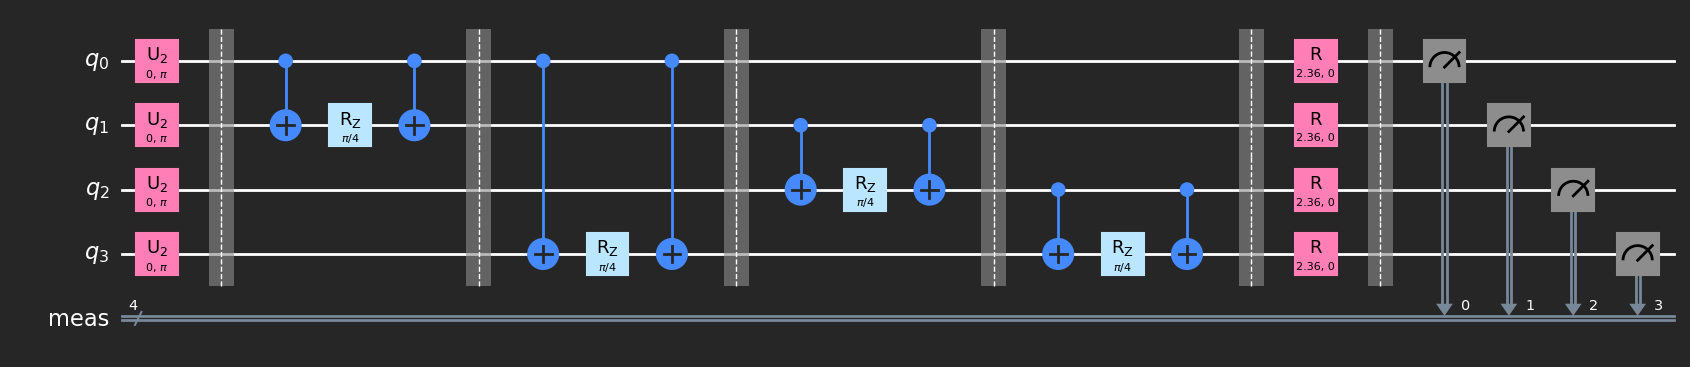

In [507]:
n = 4
graph = 'cycle'
# parameters = 'random'
parameters = [pi/8.000, pi/2.666] # max cut

qaoa_qc = qaoa(n, [graph, parameters])

decomposer(qaoa_qc, 1).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

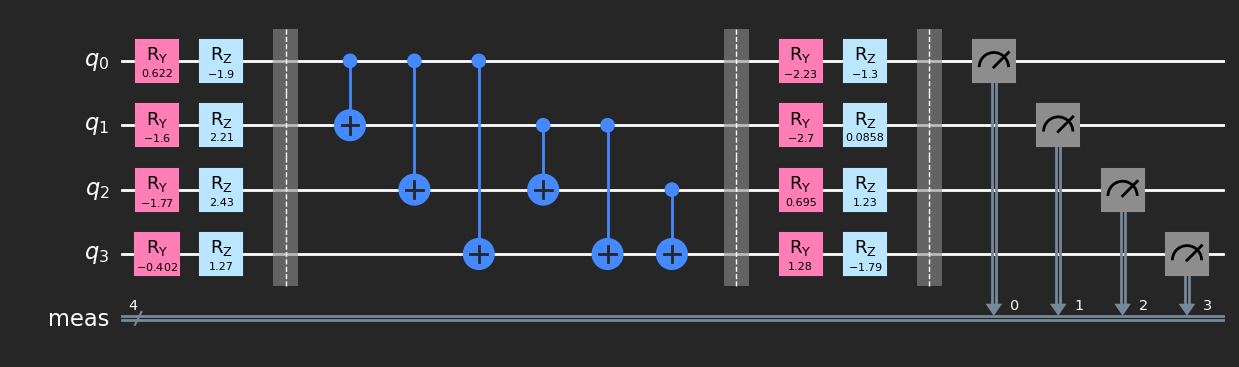

In [503]:
n = 4
repeat = 1
gates = ['ry', 'rz']
entanglement = 'full' # full, linear, reverse_linear, circular, sca
params = 'random'

vqe_qc = vqe(n, [repeat, gates, entanglement, params])

decomposer(vqe_qc, 1).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

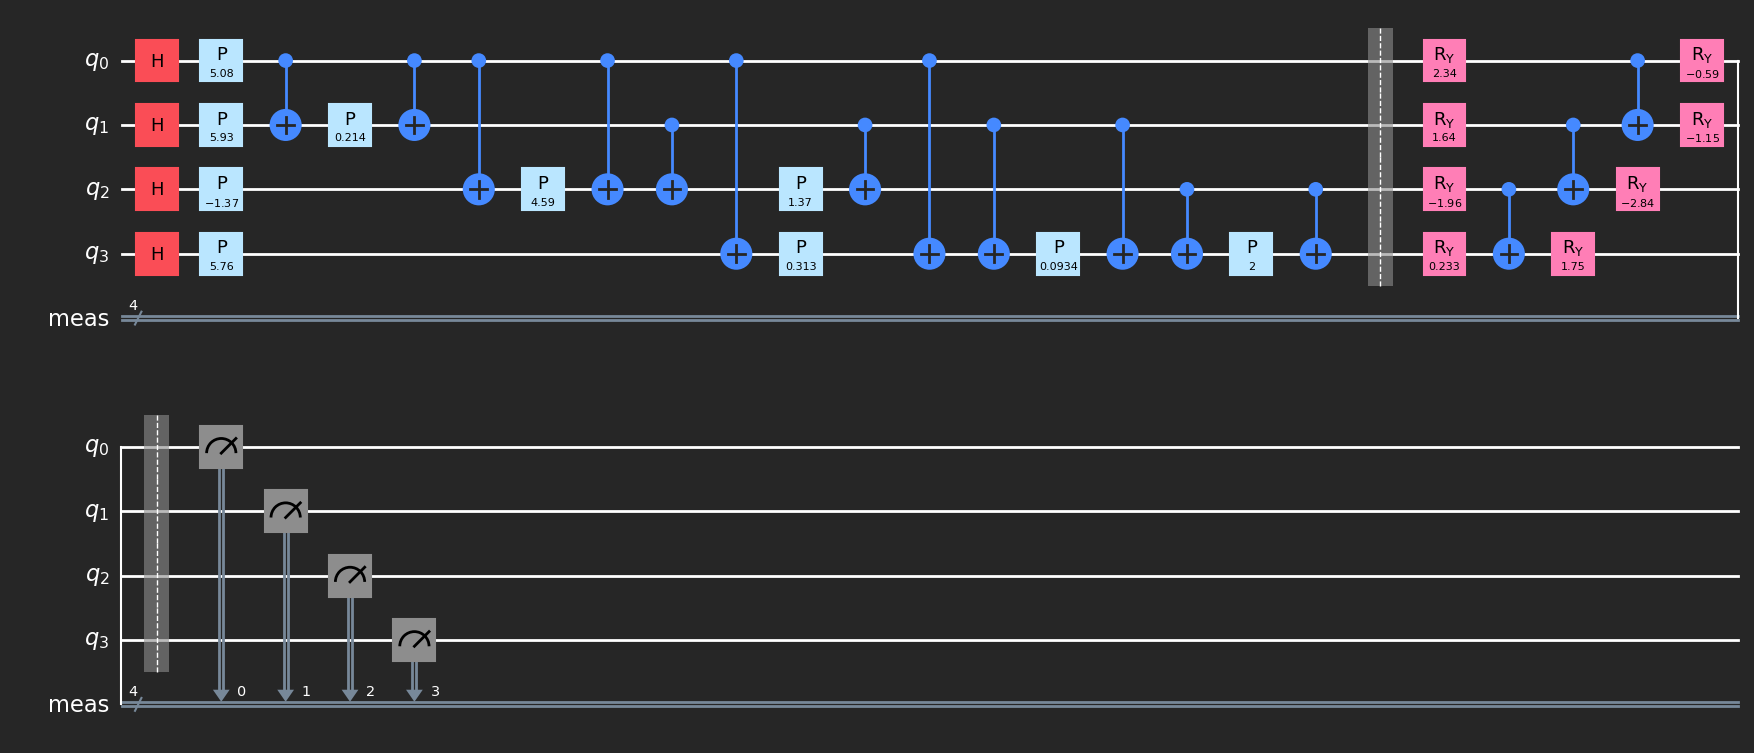

In [504]:
n = 4
repeat_f = 1
repeat_v = 1
parameters = 'random'

vqc_qc = vqc(n, [repeat_f, repeat_v, parameters])

decomposer(vqc_qc, 2).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

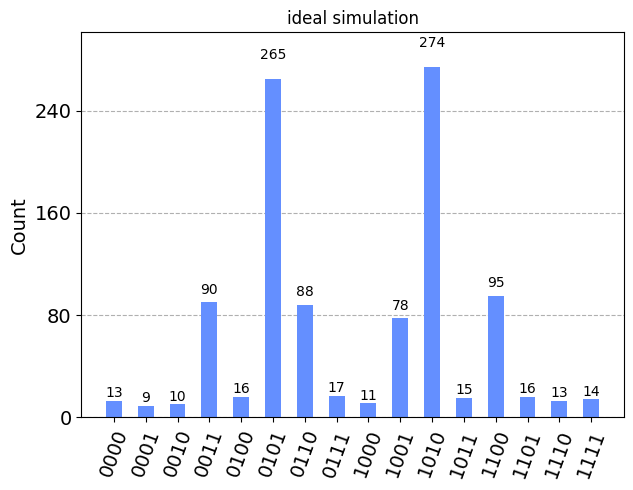

CPU times: user 204 ms, sys: 98.8 ms, total: 303 ms
Wall time: 182 ms


In [508]:
%%time

qc = qaoa_qc
shots = 1024
optimization_level = 0
seed = None
show_plot = True
show_counts = False

sorted_counts, raw_counts = run_ideal_simulation(qc, shots, optimization_level, seed, show_plot, show_counts)